In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D



import tensorflow_hub as hub


%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Sepakmed.zip

Archive:  /content/drive/MyDrive/Sepakmed.zip
   creating: Sepakmed/im_Dyskeratotic/
  inflating: Sepakmed/im_Dyskeratotic/001_01.bmp  
  inflating: Sepakmed/im_Dyskeratotic/001_02.bmp  
  inflating: Sepakmed/im_Dyskeratotic/001_03.bmp  
  inflating: Sepakmed/im_Dyskeratotic/001_04.bmp  
  inflating: Sepakmed/im_Dyskeratotic/001_05.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_01.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_02.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_03.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_04.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_05.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_06.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_07.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_08.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_09.bmp  
  inflating: Sepakmed/im_Dyskeratotic/002_10.bmp  
  inflating: Sepakmed/im_Dyskeratotic/003_01.bmp  
  inflating: Sepakmed/im_Dyskeratotic/003_02.bmp  
  inflating: Sepakmed/im_Dyskeratotic/003_03.bmp

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

**Image_Preprocessing**

In [ ]:
base_ds = '/content/Sepakmed'
base_ds = pathlib.Path(base_ds)

In [ ]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 4049 files [00:01, 2081.55 files/s]


In [ ]:
dyskeratotic = [fn for fn in os.listdir(f'{base_ds}/im_Dyskeratotic') if fn.endswith('.bmp')]
koilocytotic = [fn for fn in os.listdir(f'{base_ds}/im_Koilocytotic') if fn.endswith('.bmp')]
metaplastic = [fn for fn in os.listdir(f'{base_ds}/im_Metaplastic') if fn.endswith('.bmp')]
parabasal = [fn for fn in os.listdir(f'{base_ds}/im_Parabasal') if fn.endswith('.bmp')]
superficial_intermediate = [fn for fn in os.listdir(f'{base_ds}/im_Superficial-Intermediate') if fn.endswith('.bmp')]
cancer= [dyskeratotic, koilocytotic, metaplastic, parabasal, superficial_intermediate]
cancer_classes = []
for i in os.listdir('imgs/train'):
    cancer_classes+=[i]
cancer_classes.sort()




In [ ]:
print(cancer_classes)

['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']


Total images: 4049
Total number of classes: 5
Total im_Dyskeratotic images: 813
Total im_Koilocytotic images: 825
Total im_Metaplastic images: 793
Total im_Parabasal images: 787
Total im_Superficial-Intermediate images: 831


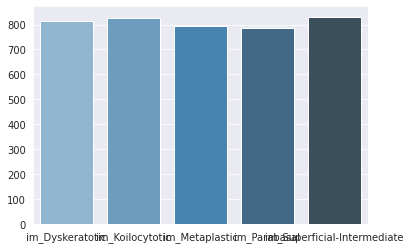

In [ ]:
image_count = len(list(base_ds.glob('*/*.bmp')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(cancer_classes)}')
count = 0
cancer_count = []
for x in cancer_classes:
  print(f'Total {x} images: {len(cancer[count])}')
  cancer_count.append(len(cancer[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=cancer_classes, y=cancer_count, palette="Blues_d")
plt.show()

Image dimensions: (215, 244, 3)


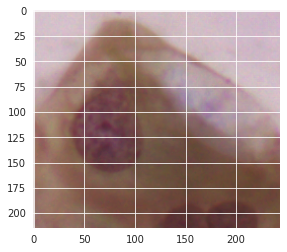

In [ ]:
sample_img = cv2.imread('/content/Sepakmed/im_Koilocytotic/003_01.bmp')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [ ]:
def load_random_img(dir, label):
  plt.figure(figsize=(15,15))
  i=0
  for label in cancer_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

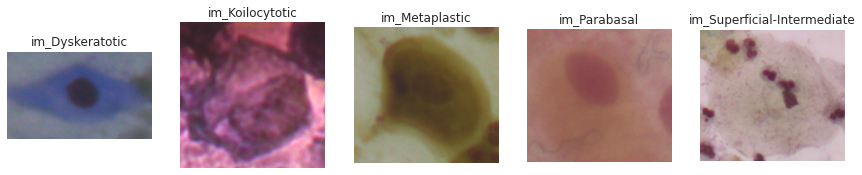

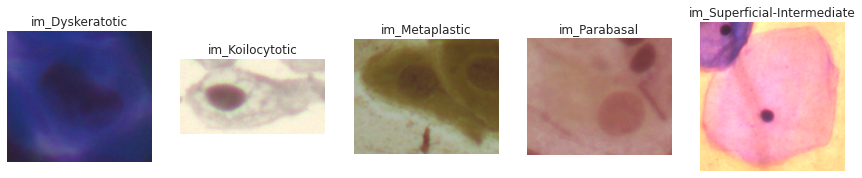

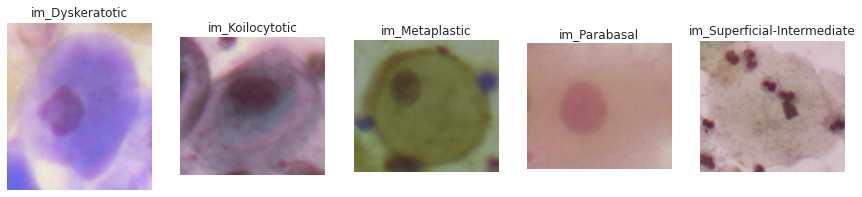

In [ ]:
for i in range(3):
  load_random_img(base_ds, cancer_classes)

In [ ]:
batch_size = 100
img_height, img_width = 224,224
input_shape = (img_height, img_width, 3)

In [ ]:
datagen = ImageDataGenerator( rescale = 1./255 , horizontal_flip=True)


In [ ]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical',shuffle=True)

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=True)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 2832 images belonging to 5 classes.
Found 604 images belonging to 5 classes.
Found 613 images belonging to 5 classes.


In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

**Vanilla cnn**

In [69]:
model = Sequential() 
# Convolutional Layer with input shape (64,64,3)
model.add(Conv2D(filters=16, kernel_size= (3,3), activation= 'relu', input_shape=(224,224,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']  )
 
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)      

In [70]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history1 = model.fit(train_ds, epochs = 50,validation_data = val_ds,callbacks=callbacks)

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8937
Epoch 1: val_accuracy improved from 0.89238 to 0.89735, saving model to saved_models/model.hdf5
29/29 [==============================] - 8s 277ms/step - loss: 0.2990 - accuracy: 0.8937 - val_loss: 0.3220 - val_accuracy: 0.8974 - lr: 1.0000e-04
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8919
Epoch 2: val_accuracy did not improve from 0.89735
29/29 [==============================] - 8s 269ms/step - loss: 0.3014 - accuracy: 0.8919 - val_loss: 0.3401 - val_accuracy: 0.8825 - lr: 1.0000e-04
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.8972
Epoch 3: val_accuracy improved from 0.89735 to 0.90066, saving model to saved_models/model.hdf5
29/29 [==============================] - 8s 274ms/step - loss: 0.2904 - accuracy: 0.8972 - val_loss: 0.3196 - val_accuracy: 0.9007 - lr: 1.0000e-04
Epoch 4/50
29/29 [=============

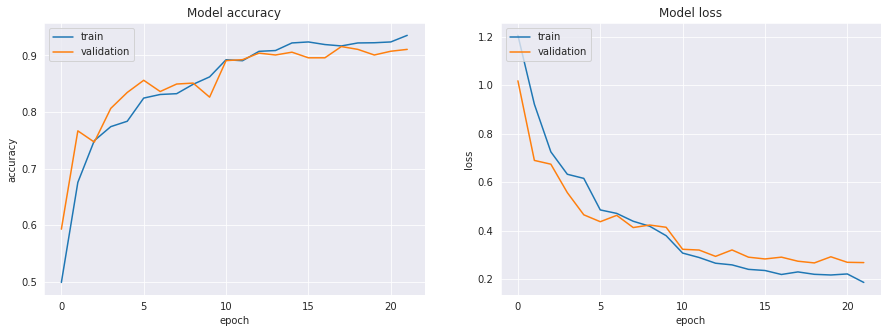

In [ ]:
model.load_weights('saved_models/model.hdf5')
plot_train_history(history1)

In [ ]:
score1 = model.evaluate(test_ds, verbose=1)

7/7 [==============================] - 1s 149ms/step - loss: 0.2955 - accuracy: 0.8874


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_ds)

7/7 [==============================] - 1s 128ms/step


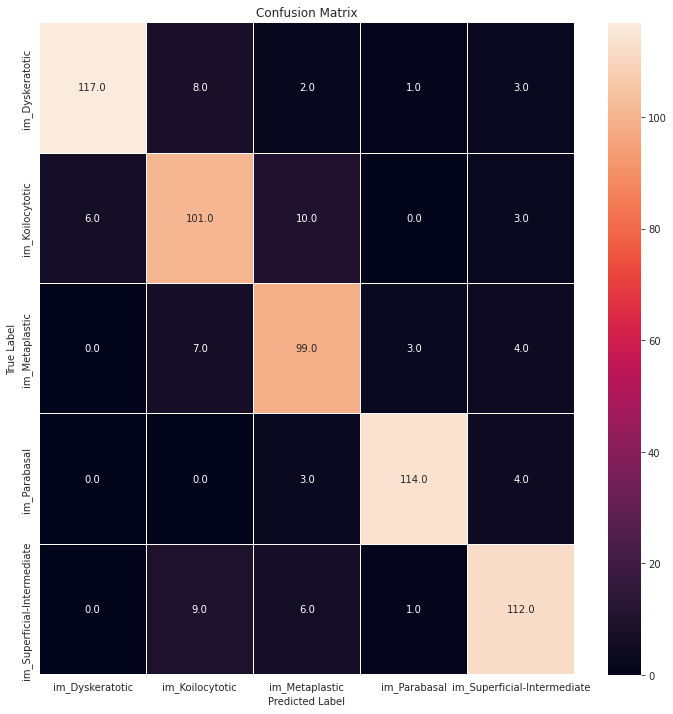

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report1 = classification_report(test_ds.classes, y_pred, target_names=cancer_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

precision    recall  f1-score     support
im_Dyskeratotic               0.893130  0.951220  0.921260  123.000000
im_Koilocytotic               0.841667  0.808000  0.824490  125.000000
im_Metaplastic                0.876106  0.825000  0.849785  120.000000
im_Parabasal                  0.942149  0.957983  0.950000  119.000000
im_Superficial-Intermediate   0.875000  0.888889  0.881890  126.000000
accuracy                      0.885808  0.885808  0.885808    0.885808
macro avg                     0.885610  0.886218  0.885485  613.000000
weighted avg                  0.885093  0.885808  0.885022  613.000000

In [ ]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = cancer_classes[np.argmax(score)]
    plt.title(f'Truth: {cancer_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [ ]:
!pip install keras-vis

!pip install tensorflow

!pip install tf-keras-vis tensorflow
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
from matplotlib import pyplot as plt
# %matplotlib inline
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from vis.utils import utils
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from tensorflow.keras.applications.densenet import decode_predictions
from tensorflow.keras.applications.resnet50 import decode_predictions
import json

#utility function to show images
def display_imgs(images):
  subprot_args = {
   'nrows': 1,
   'ncols': 5,
   'figsize': (6, 3),
   'subplot_kw': {'xticks': [], 'yticks': []}
  }
  f, ax = plt.subplots(**subprot_args)
  for i in range(len(images)):
    ax[i].imshow(images[i])
  plt.tight_layout()
  plt.show()

# Load model



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = Model(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 25s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
img1 = load_img('/content/Sepakmed/im_Dyskeratotic/001_01.bmp', target_size=(224, 224))
img2 = load_img('/content/Sepakmed/im_Koilocytotic/001_01.bmp', target_size=(224, 224))
img3 = load_img('/content/Sepakmed/im_Metaplastic/001_01.bmp', target_size=(224, 224))
img4 = load_img('/content/Sepakmed/im_Parabasal/001_01.bmp', target_size=(224, 224))
#img5 = load_img('/content/download (1).jpg', target_size=(224, 224))
img5 = load_img('/content/Sepakmed/im_Superficial-Intermediate/001_01.bmp', target_size=(224, 224))

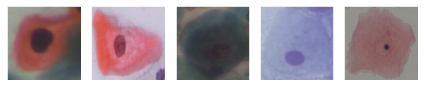

In [ ]:
#create array of images
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4),np.array(img5)])

#show images
display_imgs(images)

#convert to numpy array for reshaping
img1 = img_to_array(img1)
img2 = img_to_array(img2)
img3 = img_to_array(img3)
img4 = img_to_array(img4)
img5= img_to_array(img5)
#reshape to prepare for processing
img1 = img1.reshape(1,224,224,3)
img2 = img2.reshape(1,224,224,3)
img3 = img3.reshape(1,224,224,3)
img4 = img4.reshape(1,224,224,3)
img5 = img5.reshape(1,224,224,3)
#preprocess to prepare for input
img1 = preprocess_input(img1)
img2 = preprocess_input(img2)
img3 = preprocess_input(img3)
img4 = preprocess_input(img4)
img5 = preprocess_input(img5)


In [ ]:
yhat1 = model.predict(img1)
yhat2 = model.predict(img2)
yhat3 = model.predict(img3)
yhat4 = model.predict(img4)
yhat5 = model.predict(img5)
#decode predictions
label1 = decode_predictions(yhat1)
label2 = decode_predictions(yhat2)
label3 = decode_predictions(yhat3)
label4 = decode_predictions(yhat4)
label5 = decode_predictions(yhat5)
# extract top most prediction for each input
label1 = label1[0][0]
label2 = label2[0][0]
label3 = label3[0][0]
label4 = label4[0][0]
label5 = label5[0][0]

35363/35363 [==============================] - 0s 0us/step


In [ ]:
#plt.imshow(image1)
print('%s (%.2f%%)' % (label1[1], label1[2]*100))
#plt.imshow(image2)
print('%s (%.2f%%)' % (label2[1], label2[2]*100))
#plt.imshow(image3)
print('%s (%.2f%%)' % (label3[1], label3[2]*100))
#plt.imshow(image4)
print('%s (%.2f%%)' % (label4[1], label4[2]*100))
print('%s (%.2f%%)' % (label5[1], label5[2]*100))

goldfish (11.71%)
rubber_eraser (11.01%)
axolotl (10.71%)
Petri_dish (8.57%)
bonnet (15.70%)


In [ ]:
!wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

--2022-12-08 13:36:13--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0s      

2022-12-08 13:36:14 (147 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [ ]:
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))

#Top 5 classes predicted
class_idxs_sorted1 = np.argsort(yhat1.flatten())[::-1]
class_idxs_sorted2 = np.argsort(yhat2.flatten())[::-1]
class_idxs_sorted3 = np.argsort(yhat3.flatten())[::-1]
class_idxs_sorted4 = np.argsort(yhat4.flatten())[::-1]
class_idxs_sorted5 = np.argsort(yhat5.flatten())[::-1]
topNclass         = 6
print('\nfirst image\n')
for i, idx in enumerate(class_idxs_sorted1[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat1[0,idx]))

print('\nsecond image\n')
for i, idx in enumerate(class_idxs_sorted2[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat2[0,idx]))

print('\nthird image\n')
for i, idx in enumerate(class_idxs_sorted3[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat3[0,idx]))

print('\nFourth image\n')
for i, idx in enumerate(class_idxs_sorted4[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat4[0,idx]))
    

print('\nFifth image\n')
for i, idx in enumerate(class_idxs_sorted4[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat5[0,idx]))


N of class=1000

first image

Top 1 predicted class:     Pr(Class=goldfish           [index=1])=0.117
Top 2 predicted class:     Pr(Class=hamster            [index=333])=0.040
Top 3 predicted class:     Pr(Class=ocarina            [index=684])=0.040
Top 4 predicted class:     Pr(Class=ladybug            [index=301])=0.028
Top 5 predicted class:     Pr(Class=rock_beauty        [index=392])=0.023
Top 6 predicted class:     Pr(Class=piggy_bank         [index=719])=0.022

second image

Top 1 predicted class:     Pr(Class=rubber_eraser      [index=767])=0.110
Top 2 predicted class:     Pr(Class=piggy_bank         [index=719])=0.043
Top 3 predicted class:     Pr(Class=tick               [index=78])=0.036
Top 4 predicted class:     Pr(Class=mitten             [index=658])=0.035
Top 5 predicted class:     Pr(Class=pick               [index=714])=0.035
Top 6 predicted class:     Pr(Class=pomegranate        [index=957])=0.033

third image

Top 1 predicted class:     Pr(Class=axolotl            [

In [ ]:
# swap softmax layer with linear layer 
layer_idx = utils.find_layer_idx(model, 'predictions')
model.layers[-1].activation = tf.keras.activations.linear
model = utils.apply_modifications(model)

#get the input image index
from tf_keras_vis.utils.scores import CategoricalScore
#cat - 281, dog -235 , hen -8, tiger - 292
score = CategoricalScore([1,767,29,712,452])

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

input_classes = ['im_Dyskeratotic','im_Koilocytotic','im_Metaplastic','im_Parabasal','im_Superficial-Intermediate']

**Gradcam**

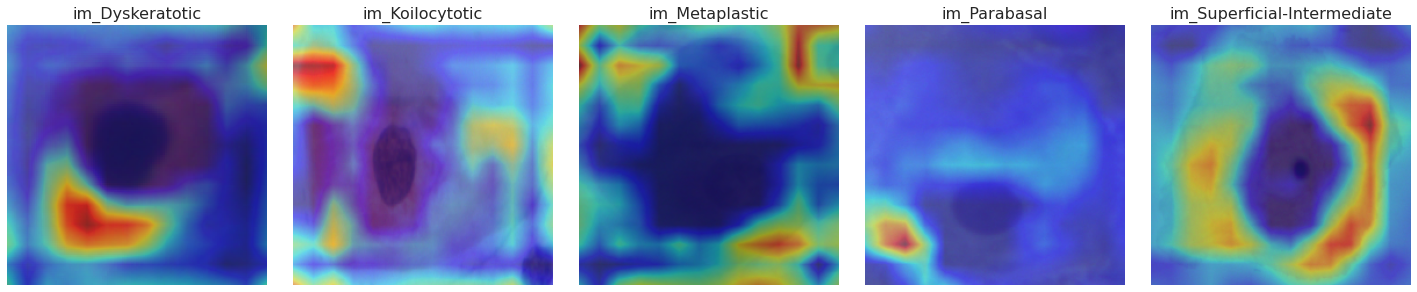

In [ ]:
input_images = preprocess_input(images)

# Create Gradcam object
gradcam = Gradcam(model,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              input_images,
              penultimate_layer=-1)

#show generated images
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, img_class in enumerate(input_classes):
    heatmap = np.uint8(cm.jet(cam[i])[..., :5] * 255)
    ax[i].set_title(img_class, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**RESNET50**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
pre_trained = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.0001)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

model_resnet = tf.keras.Model(inputs = pre_trained.input, outputs = predictions)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_resnet50.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.00001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
historyresnet50 = model_resnet.fit(train_ds, epochs = 60, validation_data = val_ds, callbacks=callbacks)

Epoch 1/60
29/29 [==============================] - ETA: 0s - loss: 1.6809 - accuracy: 0.8319
Epoch 1: val_accuracy did not improve from 0.92715
29/29 [==============================] - 31s 1s/step - loss: 1.6809 - accuracy: 0.8319 - val_loss: 3345.1680 - val_accuracy: 0.2053 - lr: 2.0000e-04
Epoch 2/60
29/29 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.9075
Epoch 2: val_accuracy did not improve from 0.92715
29/29 [==============================] - 31s 1s/step - loss: 0.4469 - accuracy: 0.9075 - val_loss: 545.2604 - val_accuracy: 0.2036 - lr: 2.0000e-04
Epoch 3/60
29/29 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9400
Epoch 3: val_accuracy did not improve from 0.92715
29/29 [==============================] - 31s 1s/step - loss: 0.1958 - accuracy: 0.9400 - val_loss: 54.5697 - val_accuracy: 0.2036 - lr: 2.0000e-04
Epoch 4/60
29/29 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9703
Epoch 4: val_accuracy did n

In [ ]:
model_resnet.load_weights('saved_models/model_resnet50.hdf5')

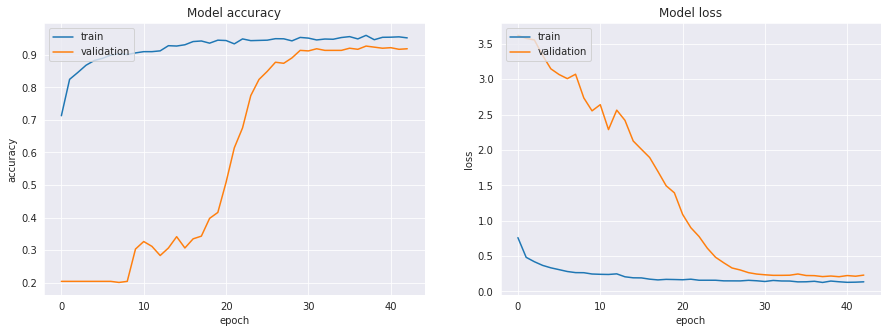

In [ ]:
plot_train_history(historyresnet50)

In [ ]:

score1 = model_resnet.evaluate(test_ds, verbose=1)

print(f'Model 2 Resnet50 Loss: {score1[0]}, Accuracy: {score1[1]*100}')

7/7 [==============================] - 3s 354ms/step - loss: 0.2357 - accuracy: 0.9086
Model 2 Resnet50 Loss: 0.2357453554868698, Accuracy: 90.86459875106812


**FINE_TUNING**

In [ ]:
for layer in pre_trained.layers:
    layer.trainable = True
    x = pre_trained.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.0001)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

model_resnet = tf.keras.Model(inputs = pre_trained.input, outputs = predictions)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historyresnet50 = model_resnet.fit(train_ds, epochs = 60, validation_data = val_ds, callbacks=callbacks)

Epoch 1/60
29/29 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.8033
Epoch 1: val_accuracy did not improve from 0.92715
29/29 [==============================] - 43s 1s/step - loss: 0.7103 - accuracy: 0.8033 - val_loss: 17359.7207 - val_accuracy: 0.2003 - lr: 0.0010
Epoch 2/60
29/29 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.8736
Epoch 2: val_accuracy did not improve from 0.92715
29/29 [==============================] - 31s 1s/step - loss: 0.5118 - accuracy: 0.8736 - val_loss: 385260.4375 - val_accuracy: 0.2003 - lr: 0.0010
Epoch 3/60
29/29 [==============================] - ETA: 0s - loss: 0.5578 - accuracy: 0.8930
Epoch 3: val_accuracy did not improve from 0.92715
29/29 [==============================] - 31s 1s/step - loss: 0.5578 - accuracy: 0.8930 - val_loss: 1.9805 - val_accuracy: 0.1954 - lr: 0.0010
Epoch 4/60
29/29 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8775
Epoch 4: val_accuracy did not improv

In [ ]:
model_resnet.load_weights('saved_models/model_resnet50.hdf5')

In [ ]:
score8 = model_resnet.evaluate(test_ds, verbose=1)

print(f'Model 2 Resnet Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 Resnet Fine-tuned Loss: {score8[0]}, Accuracy: {score8[1]*100}')

7/7 [==============================] - 2s 278ms/step - loss: 0.2333 - accuracy: 0.9168
Model 2 Resnet Loss: 0.2357453554868698, Accuracy: 90.86459875106812
Model 2 Resnet Fine-tuned Loss: 0.23333097994327545, Accuracy: 91.68025851249695


In [ ]:
Y_pred = model_resnet.predict(test_ds)

7/7 [==============================] - 3s 317ms/step


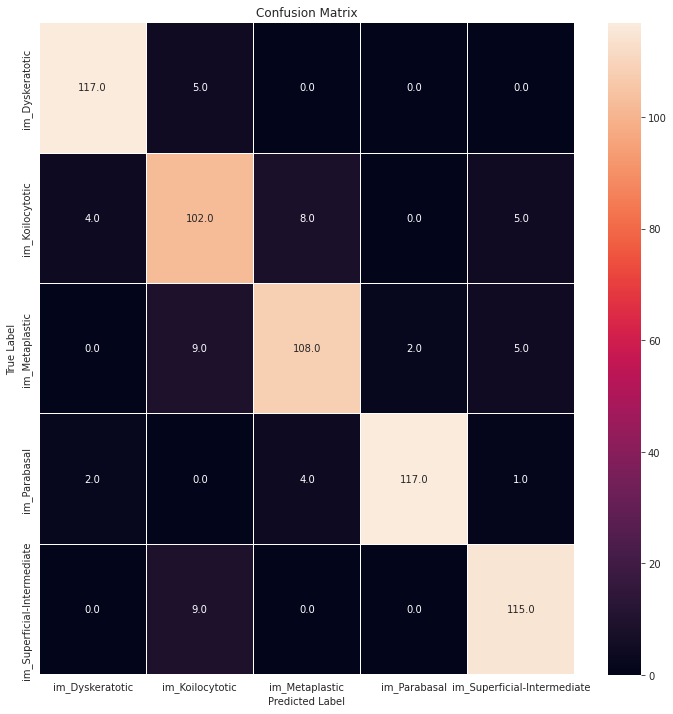

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report_resnet = classification_report(test_ds.classes, y_pred, target_names=cancer_classes, output_dict=True)
df_resnet = pd.DataFrame(report_resnet).transpose()
df_resnet

precision    recall  f1-score     support
im_Dyskeratotic               0.950000  0.926829  0.938272  123.000000
im_Koilocytotic               0.842975  0.816000  0.829268  125.000000
im_Metaplastic                0.875000  0.875000  0.875000  120.000000
im_Parabasal                  0.914062  0.983193  0.947368  119.000000
im_Superficial-Intermediate   0.911290  0.896825  0.904000  126.000000
accuracy                      0.898858  0.898858  0.898858    0.898858
macro avg                     0.898666  0.899570  0.898782  613.000000
weighted avg                  0.898561  0.898858  0.898380  613.000000

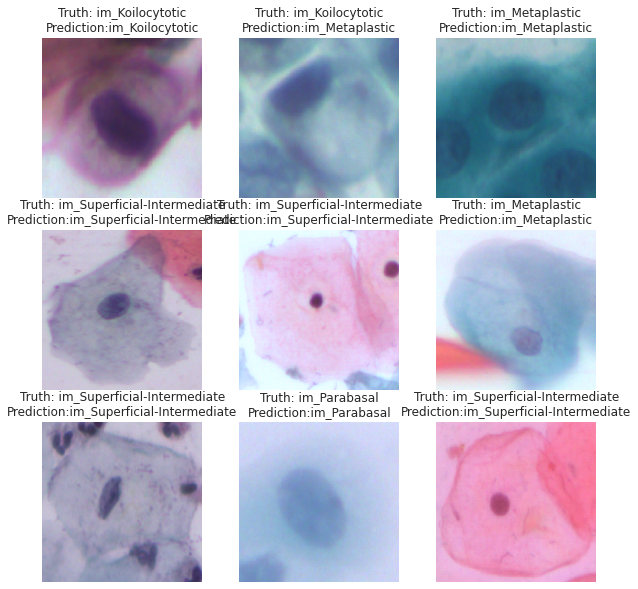

In [ ]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_resnet(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = cancer_classes[np.argmax(score)]
    plt.title(f'Truth: {cancer_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input

resnet = ResNet50(weights='imagenet')

In [ ]:
yhat1 = resnet.predict(img1)
yhat2 = resnet.predict(img2)
yhat3 = resnet.predict(img3)
yhat4 = resnet.predict(img4)
yhat5 = resnet.predict(img5)
#decode predictions
label1 = decode_predictions(yhat1)
label2 = decode_predictions(yhat2)
label3 = decode_predictions(yhat3)
label4 = decode_predictions(yhat4)
label5 = decode_predictions(yhat5)
# extract top most prediction for each input
label1 = label1[0][0]
label2 = label2[0][0]
label3 = label3[0][0]
label4 = label4[0][0]
label5 = label5[0][0]

1/1 [==============================] - 0s 22ms/step


In [ ]:
#plt.imshow(image1)
print('%s (%.2f%%)' % (label1[1], label1[2]*100))
#plt.imshow(image2)
print('%s (%.2f%%)' % (label2[1], label2[2]*100))
#plt.imshow(image3)
print('%s (%.2f%%)' % (label3[1], label3[2]*100))
#plt.imshow(image4)
print('%s (%.2f%%)' % (label4[1], label4[2]*100))
print('%s (%.2f%%)' % (label5[1], label5[2]*100))

ocarina (70.63%)
rubber_eraser (43.09%)
fig (51.54%)
paper_towel (14.72%)
hair_slide (13.57%)


In [ ]:
layer_idx = utils.find_layer_idx(resnet, 'predictions')
resnet.layers[-1].activation = tf.keras.activations.linear
resnet = utils.apply_modifications(resnet)

#get the input image index
from tf_keras_vis.utils.scores import CategoricalScore
#cat - 281, dog -235 , hen -8, tiger - 292
score = CategoricalScore([684,767,952,700,584])

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

input_classes = ['im_Dyskeratotic','im_Koilocytotic','im_Metaplastic','im_Parabasal','im_Superficial-Intermediate']

**GRADCAM**

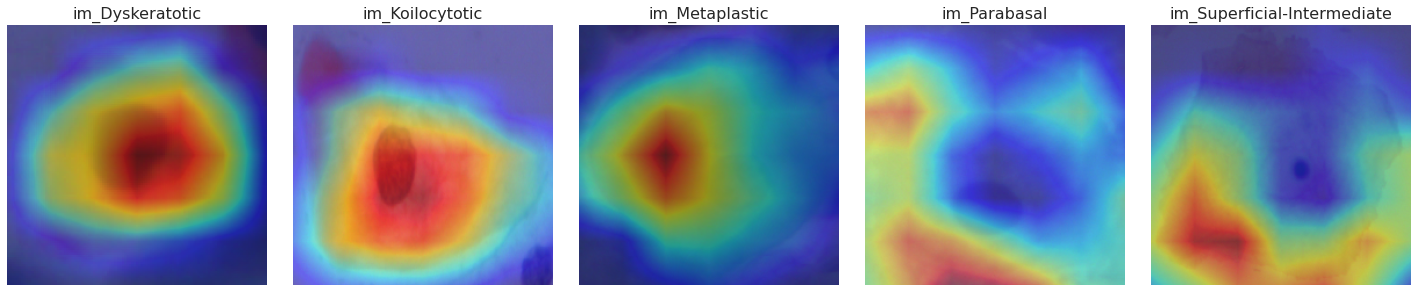

In [ ]:

# Create Gradcam object
gradcam = Gradcam(resnet,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              input_images,
              penultimate_layer=-1)

#show generated images



f, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, img_class in enumerate(input_classes):
    heatmap = np.uint8(cm.jet(cam[i])[..., :5] * 255)
    ax[i].set_title(img_class, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**Vgg16**

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

In [ ]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 dense_13 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
_________________________________________

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history2 = model_vgg16.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks=callbacks)

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 1.3505 - accuracy: 0.4590
Epoch 1: val_accuracy improved from -inf to 0.61921, saving model to saved_models/model_vgg16.hdf5
29/29 [==============================] - 31s 735ms/step - loss: 1.3505 - accuracy: 0.4590 - val_loss: 1.1139 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 1.0492 - accuracy: 0.6222
Epoch 2: val_accuracy improved from 0.61921 to 0.69040, saving model to saved_models/model_vgg16.hdf5
29/29 [==============================] - 18s 631ms/step - loss: 1.0492 - accuracy: 0.6222 - val_loss: 0.9012 - val_accuracy: 0.6904 - lr: 0.0010
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.8964 - accuracy: 0.6889
Epoch 3: val_accuracy improved from 0.69040 to 0.69702, saving model to saved_models/model_vgg16.hdf5
29/29 [==============================] - 19s 646ms/step - loss: 0.8964 - accuracy: 0.6889 - val_loss: 0.8034 - val_accuracy: 

KeyboardInterrupt: ignored

In [ ]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

In [ ]:
plot_train_history(history2)

In [ ]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)

print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

7/7 [==============================] - 5s 690ms/step - loss: 0.4259 - accuracy: 0.8483
Model 2 VGG16 Loss: 0.4258725643157959, Accuracy: 84.82871055603027


**Fine_Tunning**

In [ ]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history3 = model_vgg16.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks=callbacks)

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8415
Epoch 1: val_accuracy improved from 0.87583 to 0.89073, saving model to saved_models/model_vgg16.hdf5
29/29 [==============================] - 63s 2s/step - loss: 0.4264 - accuracy: 0.8415 - val_loss: 0.2813 - val_accuracy: 0.8907 - lr: 1.0000e-05
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9167
Epoch 2: val_accuracy improved from 0.89073 to 0.92384, saving model to saved_models/model_vgg16.hdf5
29/29 [==============================] - 46s 2s/step - loss: 0.2307 - accuracy: 0.9167 - val_loss: 0.2015 - val_accuracy: 0.9238 - lr: 1.0000e-05
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9347
Epoch 3: val_accuracy improved from 0.92384 to 0.92881, saving model to saved_models/model_vgg16.hdf5
29/29 [==============================] - 46s 2s/step - loss: 0.1838 - accuracy: 0.9347 - val_loss: 0.2008 - val_accuracy

In [ ]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

In [ ]:
score3 = model_vgg16.evaluate(test_ds, verbose=1)

print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score3[0]}, Accuracy: {score3[1]*100}')

7/7 [==============================] - 3s 455ms/step - loss: 0.1975 - accuracy: 0.9233
Model 2 VGG16 Loss: 0.4258725643157959, Accuracy: 84.82871055603027
Model 2 VGG16 Fine-tuned Loss: 0.19752158224582672, Accuracy: 92.33279228210449


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vgg16.predict(test_ds)

7/7 [==============================] - 3s 521ms/step


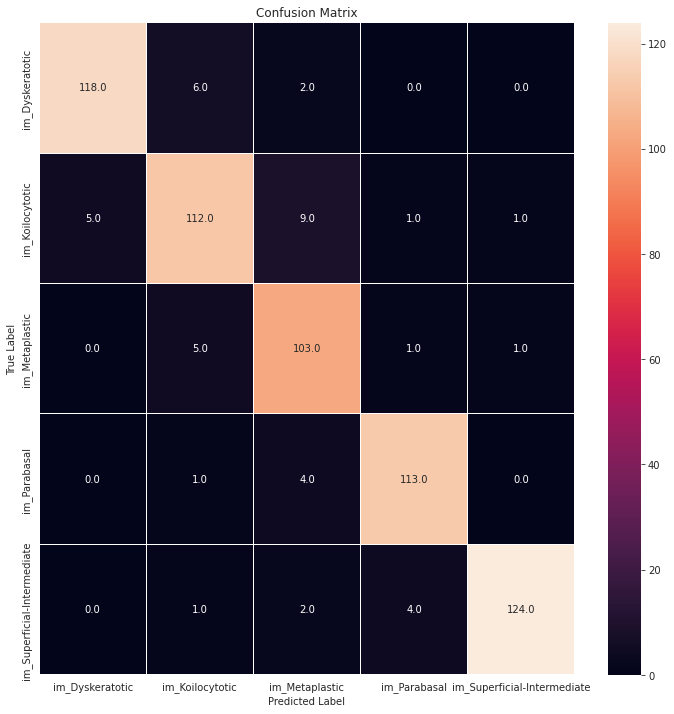

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report2 = classification_report(test_ds.classes, y_pred, target_names=cancer_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

precision    recall  f1-score     support
im_Dyskeratotic               0.936508  0.959350  0.947791  123.000000
im_Koilocytotic               0.875000  0.896000  0.885375  125.000000
im_Metaplastic                0.936364  0.858333  0.895652  120.000000
im_Parabasal                  0.957627  0.949580  0.953586  119.000000
im_Superficial-Intermediate   0.946565  0.984127  0.964981  126.000000
accuracy                      0.929853  0.929853  0.929853    0.929853
macro avg                     0.930413  0.929478  0.929477  613.000000
weighted avg                  0.930104  0.929853  0.929515  613.000000

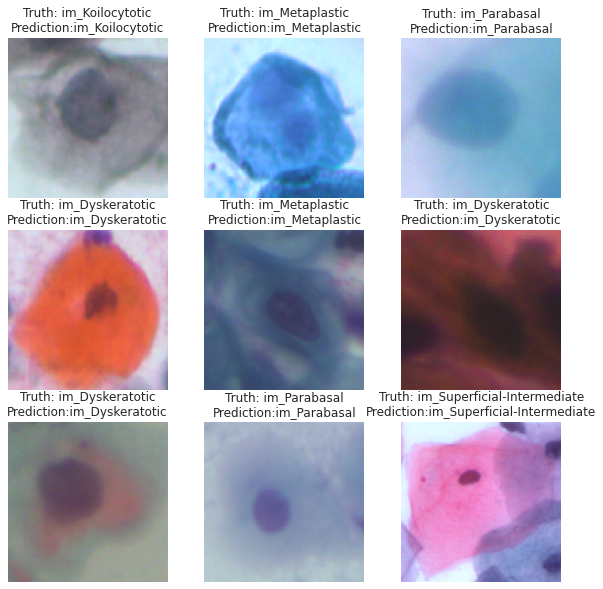

In [ ]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = cancer_classes[np.argmax(score)]
    plt.title(f'Truth: {cancer_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [ ]:
model_vgg16 = Model(weights='imagenet', include_top=True)
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input

import numpy as np
from matplotlib import pyplot as plt
# %matplotlib inline
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from vis.utils import utils
from tensorflow.keras.applications.vgg16 import decode_predictions
import json
def display_imgs(images):
  subprot_args = {
   'nrows': 1,
   'ncols': 5,
   'figsize': (6, 3),
   'subplot_kw': {'xticks': [], 'yticks': []}
  }
  f, ax = plt.subplots(**subprot_args)
  for i in range(len(images)):
    ax[i].imshow(images[i])
  plt.tight_layout()
  plt.show()



In [ ]:
img1 = load_img('/content/Sepakmed/im_Dyskeratotic/001_01.bmp', target_size=(224, 224))
img2 = load_img('/content/Sepakmed/im_Koilocytotic/001_01.bmp', target_size=(224, 224))
img3 = load_img('/content/Sepakmed/im_Metaplastic/001_01.bmp', target_size=(224, 224))
img4 = load_img('/content/Sepakmed/im_Parabasal/001_01.bmp', target_size=(224, 224))
img5 = load_img('/content/Sepakmed/im_Superficial-Intermediate/001_01.bmp', target_size=(224, 224))



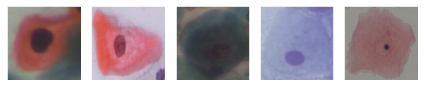

In [ ]:
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4),np.array(img5)])
#show images
display_imgs(images)

#convert to numpy array for reshaping
img1 = img_to_array(img1)
img2 = img_to_array(img2)
img3 = img_to_array(img3)
img4 = img_to_array(img4)
img5 = img_to_array(img5)
#reshape to prepare for processing
img1 = img1.reshape(1,224,224,3)
img2 = img2.reshape(1,224,224,3)
img3 = img3.reshape(1,224,224,3)
img4 = img4.reshape(1,224,224,3)
img5 = img5.reshape(1,224,224,3)
#preprocess to prepare for input
img1 = preprocess_input(img1)
img2 = preprocess_input(img2)
img3 = preprocess_input(img3)
img4 = preprocess_input(img4)
img5 = preprocess_input(img5)

In [ ]:
yhat1 = model_vgg16.predict(img1)
yhat2 = model_vgg16.predict(img2)
yhat3 = model_vgg16.predict(img3)
yhat4 = model_vgg16.predict(img4)
yhat5 = model_vgg16.predict(img5)
#decode predictions
label1 = decode_predictions(yhat1)
label2 = decode_predictions(yhat2)
label3 = decode_predictions(yhat3)
label4 = decode_predictions(yhat4)
label5 = decode_predictions(yhat5)
# extract top most prediction for each input
label1 = label1[0][0]
label2 = label2[0][0]
label3 = label3[0][0]
label4 = label4[0][0]
label5 = label5[0][0]

1/1 [==============================] - 0s 14ms/step


In [ ]:
#plt.imshow(image1)
print('%s (%.2f%%)' % (label1[1], label1[2]*100))
#plt.imshow(image2)
print('%s (%.2f%%)' % (label2[1], label2[2]*100))
#plt.imshow(image3)
print('%s (%.2f%%)' % (label3[1], label3[2]*100))
#plt.imshow(image4)
print('%s (%.2f%%)' % (label4[1], label4[2]*100))
print('%s (%.2f%%)' % (label5[1], label5[2]*100))


goldfish (11.71%)
rubber_eraser (11.01%)
axolotl (10.71%)
Petri_dish (8.57%)
bonnet (15.70%)


In [ ]:
!wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

--2022-12-06 09:52:21--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0s      

2022-12-06 09:52:21 (157 MB/s) - ‘imagenet_class_index.json.1’ saved [35363/35363]



In [ ]:
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))

#Top 5 classes predicted
class_idxs_sorted1 = np.argsort(yhat1.flatten())[::-1]
class_idxs_sorted2 = np.argsort(yhat2.flatten())[::-1]
class_idxs_sorted3 = np.argsort(yhat3.flatten())[::-1]
class_idxs_sorted4 = np.argsort(yhat4.flatten())[::-1]
class_idxs_sorted5 = np.argsort(yhat5.flatten())[::-1]
topNclass         = 6
print('\nfirst image\n')
for i, idx in enumerate(class_idxs_sorted1[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat1[0,idx]))

print('\nsecond image\n')
for i, idx in enumerate(class_idxs_sorted2[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat2[0,idx]))

print('\nthird image\n')
for i, idx in enumerate(class_idxs_sorted3[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat3[0,idx]))

print('\nFourth image\n')
for i, idx in enumerate(class_idxs_sorted4[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat4[0,idx]))
  

for i, idx in enumerate(class_idxs_sorted4[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat5[0,idx]))

N of class=1000

first image

Top 1 predicted class:     Pr(Class=goldfish           [index=1])=0.117
Top 2 predicted class:     Pr(Class=hamster            [index=333])=0.040
Top 3 predicted class:     Pr(Class=ocarina            [index=684])=0.040
Top 4 predicted class:     Pr(Class=ladybug            [index=301])=0.028
Top 5 predicted class:     Pr(Class=rock_beauty        [index=392])=0.023
Top 6 predicted class:     Pr(Class=piggy_bank         [index=719])=0.022

second image

Top 1 predicted class:     Pr(Class=rubber_eraser      [index=767])=0.110
Top 2 predicted class:     Pr(Class=piggy_bank         [index=719])=0.043
Top 3 predicted class:     Pr(Class=tick               [index=78])=0.036
Top 4 predicted class:     Pr(Class=mitten             [index=658])=0.035
Top 5 predicted class:     Pr(Class=pick               [index=714])=0.035
Top 6 predicted class:     Pr(Class=pomegranate        [index=957])=0.033

third image

Top 1 predicted class:     Pr(Class=axolotl            [

In [ ]:
layer_idx = utils.find_layer_idx(model_vgg16, 'predictions')
model_vgg16.layers[-1].activation = tf.keras.activations.linear
model_vgg16 = utils.apply_modifications(model_vgg16)

from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore([1,767,29,712,452])
# score = CategoricalScore([1,1,1,1,1])
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

input_classes = ['im_Dyskeratotic','im_Koilocytotic','im_Metaplastic','im_Parabasal','im_Superficial-Intermediate']

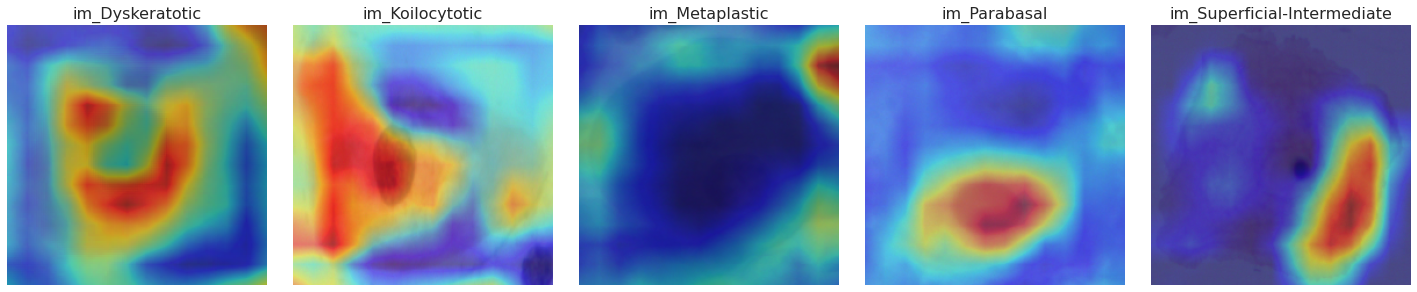

In [ ]:



# Create Gradcam object
gradcam = Gradcam(model_vgg16,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              input_images,
              penultimate_layer=-1)

#show generated images



f, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, img_class in enumerate(input_classes):
    heatmap = np.uint8(cm.jet(cam[i])[..., :5] * 255)
    ax[i].set_title(img_class, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()


**MobileNetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
mobilenet.trainable = False
inputs = tf.keras.Input(input_shape)
x = mobilenet(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
mobilenet = tf.keras.Model(inputs, x)



In [ ]:
mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_9 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 3,574,853
Trainable params: 1,316,869
Non-tra

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_MobileNetV2.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history2 = mobilenet.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks=callbacks)

Epoch 1/50
28/29 [===========================>..] - ETA: 0s - loss: 0.8283 - accuracy: 0.7221
Epoch 1: val_accuracy improved from -inf to 0.87417, saving model to saved_models/model_MobileNetV2.hdf5
29/29 [==============================] - 9s 217ms/step - loss: 0.8211 - accuracy: 0.7246 - val_loss: 0.3509 - val_accuracy: 0.8742 - lr: 0.0010
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.8764
Epoch 2: val_accuracy did not improve from 0.87417
29/29 [==============================] - 5s 175ms/step - loss: 0.3462 - accuracy: 0.8764 - val_loss: 0.3504 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 3/50
28/29 [===========================>..] - ETA: 0s - loss: 0.2728 - accuracy: 0.9032
Epoch 3: val_accuracy improved from 0.87417 to 0.88576, saving model to saved_models/model_MobileNetV2.hdf5
29/29 [==============================] - 6s 188ms/step - loss: 0.2716 - accuracy: 0.9040 - val_loss: 0.3220 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 4/50
29/29 [====

In [ ]:
mobilenet.load_weights('saved_models/model_MobileNetV2.hdf5')

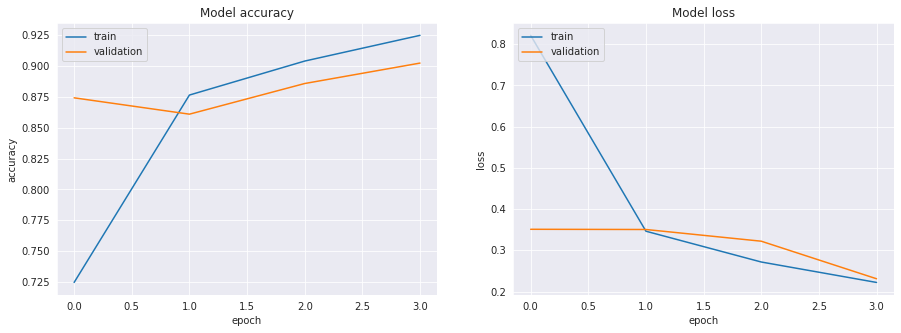

In [ ]:
plot_train_history(history2)

In [ ]:
score4 = mobilenet.evaluate(test_ds, verbose=1)

print(f'Model 2 MobileNetV2 Loss: {score4[0]}, Accuracy: {score4[1]*100}')

7/7 [==============================] - 1s 126ms/step - loss: 0.3340 - accuracy: 0.8793
Model 2 MobileNetV2 Loss: 0.33402857184410095, Accuracy: 87.92822360992432


**Fine Tunning**

In [ ]:

mobilenet.trainable = True
mobilenet.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history4 = mobilenet.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks=callbacks)

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9421
Epoch 1: val_accuracy improved from 0.90232 to 0.91556, saving model to saved_models/model_MobileNetV2.hdf5
29/29 [==============================] - 28s 771ms/step - loss: 0.1756 - accuracy: 0.9421 - val_loss: 0.2295 - val_accuracy: 0.9156 - lr: 1.0000e-05
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9597
Epoch 2: val_accuracy improved from 0.91556 to 0.92384, saving model to saved_models/model_MobileNetV2.hdf5
29/29 [==============================] - 21s 733ms/step - loss: 0.1271 - accuracy: 0.9597 - val_loss: 0.1957 - val_accuracy: 0.9238 - lr: 1.0000e-05
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9661
Epoch 3: val_accuracy improved from 0.92384 to 0.93709, saving model to saved_models/model_MobileNetV2.hdf5
29/29 [==============================] - 21s 737ms/step - loss: 0.1013 - accuracy: 0.9661 - val_

In [ ]:
mobilenet.load_weights('saved_models/model_MobileNetV2.hdf5')

In [ ]:
score5 = mobilenet.evaluate(test_ds, verbose=1)



print(f'Model 2 MobileNetv2 Loss: {score4[0]}, Accuracy: {score4[1]*100}')
print(f'Model 2 MobileNetv2 Fine-tuned Loss: {score5[0]}, Accuracy: {score5[1]*100}')

7/7 [==============================] - 1s 123ms/step - loss: 0.2563 - accuracy: 0.9168
Model 2 MobileNetv2 Loss: 0.33402857184410095, Accuracy: 87.92822360992432
Model 2 MobileNetv2 Fine-tuned Loss: 0.2562599778175354, Accuracy: 91.68025851249695


In [ ]:
Y_pred = mobilenet.predict(test_ds)

7/7 [==============================] - 2s 143ms/step


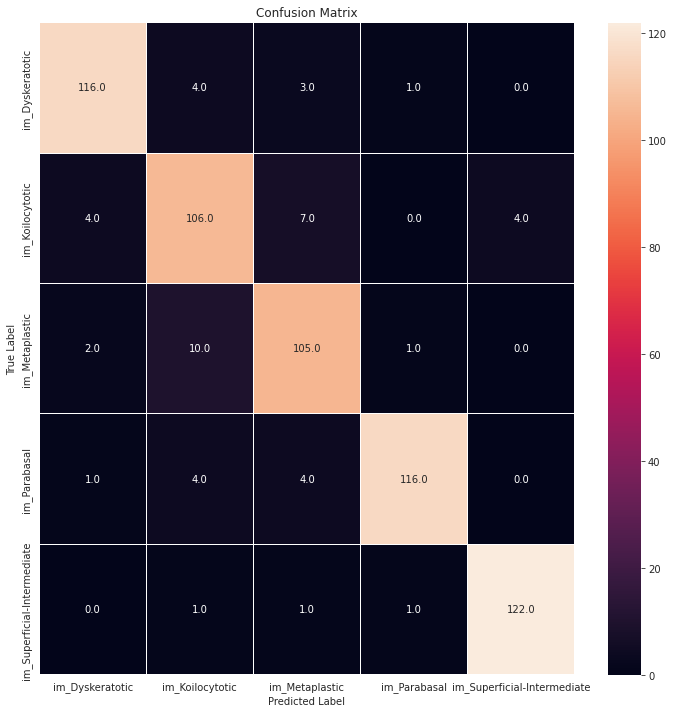

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report2 = classification_report(test_ds.classes, y_pred, target_names=cancer_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

precision    recall  f1-score     support
im_Dyskeratotic               0.935484  0.943089  0.939271  123.000000
im_Koilocytotic               0.876033  0.848000  0.861789  125.000000
im_Metaplastic                0.889831  0.875000  0.882353  120.000000
im_Parabasal                  0.928000  0.974790  0.950820  119.000000
im_Superficial-Intermediate   0.976000  0.968254  0.972112  126.000000
accuracy                      0.921697  0.921697  0.921697    0.921697
macro avg                     0.921069  0.921827  0.921269  613.000000
weighted avg                  0.921299  0.921697  0.921321  613.000000

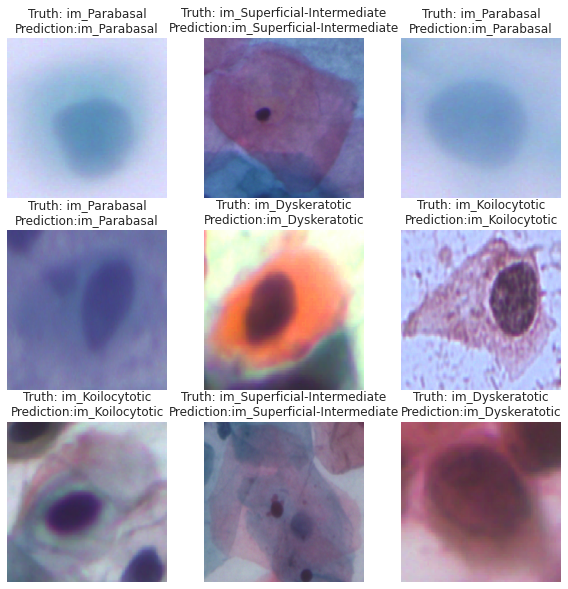

In [ ]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = mobilenet(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = cancer_classes[np.argmax(score)]
    plt.title(f'Truth: {cancer_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(weights='imagenet')

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions


14536120/14536120 [==============================] - 0s 0us/step


In [ ]:
yhat1 = mobilenet.predict(img1)
yhat2 = mobilenet.predict(img2)
yhat3 = mobilenet.predict(img3)
yhat4 = mobilenet.predict(img4)
yhat5 = mobilenet.predict(img5)
#decode predictions
label1 = decode_predictions(yhat1)
label2 = decode_predictions(yhat2)
label3 = decode_predictions(yhat3)
label4 = decode_predictions(yhat4)
label5 = decode_predictions(yhat5)
# extract top most prediction for each input
label1 = label1[0][0]
label2 = label2[0][0]
label3 = label3[0][0]
label4 = label4[0][0]
label5 = label5[0][0]

NameError: ignored

In [ ]:
#plt.imshow(image1)
print('%s (%.2f%%)' % (label1[1], label1[2]*100))
#plt.imshow(image2)
print('%s (%.2f%%)' % (label2[1], label2[2]*100))
#plt.imshow(image3)
print('%s (%.2f%%)' % (label3[1], label3[2]*100))
#plt.imshow(image4)
print('%s (%.2f%%)' % (label4[1], label4[2]*100))
print('%s (%.2f%%)' % (label5[1], label5[2]*100))

theater_curtain (66.42%)
switch (18.29%)
shower_curtain (13.96%)
shower_curtain (58.02%)
prayer_rug (3.05%)


In [ ]:
!wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

--2022-12-08 13:55:02--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0s      

2022-12-08 13:55:03 (131 MB/s) - ‘imagenet_class_index.json.1’ saved [35363/35363]



In [ ]:
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))

#Top 5 classes predicted
class_idxs_sorted1 = np.argsort(yhat1.flatten())[::-1]
class_idxs_sorted2 = np.argsort(yhat2.flatten())[::-1]
class_idxs_sorted3 = np.argsort(yhat3.flatten())[::-1]
class_idxs_sorted4 = np.argsort(yhat4.flatten())[::-1]
class_idxs_sorted5 = np.argsort(yhat5.flatten())[::-1]
topNclass         = 6
print('\nfirst image\n')
for i, idx in enumerate(class_idxs_sorted1[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat1[0,idx]))

print('\nsecond image\n')
for i, idx in enumerate(class_idxs_sorted2[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat2[0,idx]))

print('\nthird image\n')
for i, idx in enumerate(class_idxs_sorted3[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat3[0,idx]))

print('\nFourth image\n')
for i, idx in enumerate(class_idxs_sorted4[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat4[0,idx]))
  

for i, idx in enumerate(class_idxs_sorted4[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat5[0,idx]))

N of class=1000

first image

Top 1 predicted class:     Pr(Class=theater_curtain    [index=854])=0.664
Top 2 predicted class:     Pr(Class=shower_curtain     [index=794])=0.085
Top 3 predicted class:     Pr(Class=oscilloscope       [index=688])=0.072
Top 4 predicted class:     Pr(Class=lampshade          [index=619])=0.005
Top 5 predicted class:     Pr(Class=balloon            [index=417])=0.004
Top 6 predicted class:     Pr(Class=digital_clock      [index=530])=0.003

second image

Top 1 predicted class:     Pr(Class=switch             [index=844])=0.183
Top 2 predicted class:     Pr(Class=shower_curtain     [index=794])=0.085
Top 3 predicted class:     Pr(Class=projector          [index=745])=0.038
Top 4 predicted class:     Pr(Class=pillow             [index=721])=0.032
Top 5 predicted class:     Pr(Class=sunglasses         [index=837])=0.028
Top 6 predicted class:     Pr(Class=giant_panda        [index=388])=0.028

third image

Top 1 predicted class:     Pr(Class=shower_curtain   

In [ ]:
layer_idx = utils.find_layer_idx(mobilenet, 'predictions')
mobilenet.layers[-1].activation = tf.keras.activations.linear
mobilenet = utils.apply_modifications(mobilenet)

#get the input image index
from tf_keras_vis.utils.scores import CategoricalScore
#cat - 281, dog -235 , hen -8, tiger - 292
score = CategoricalScore([854,844,794,794,741])

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

input_classes = ['im_Dyskeratotic','im_Koilocytotic','im_Metaplastic','im_Parabasal','im_Superficial-Intermediate']

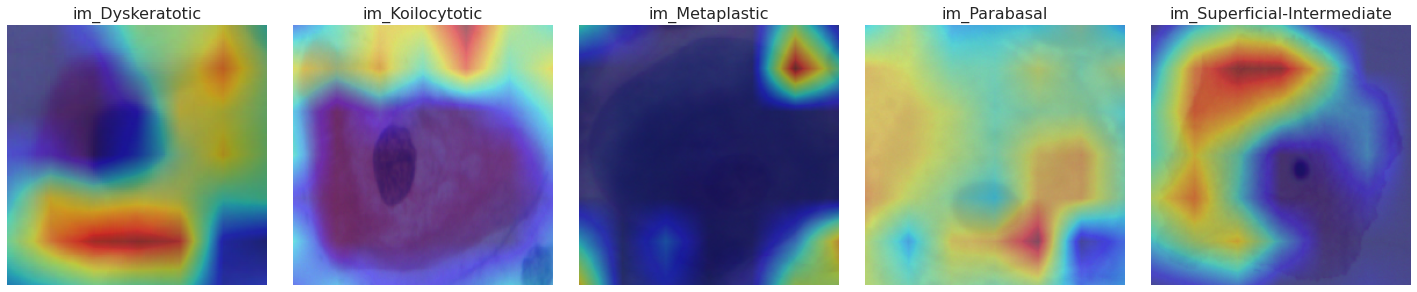

In [ ]:
input_images = preprocess_input(images)

# Create Gradcam object
gradcam = Gradcam(mobilenet,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              input_images,
              penultimate_layer=-1)

#show generated images



f, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, img_class in enumerate(input_classes):
    heatmap = np.uint8(cm.jet(cam[i])[..., :5] * 255)
    ax[i].set_title(img_class, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**DenseNet169**

In [ ]:
from keras.applications.densenet import DenseNet169


densenet = DenseNet169(weights="imagenet", include_top=False, input_shape=input_shape)
densenet.trainable = False
inputs = tf.keras.Input(input_shape)
x = densenet(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
densenet = tf.keras.Model(inputs, x)



51877672/51877672 [==============================] - 3s 0us/step


In [ ]:
densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
densenet.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_3   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 1024)              1704960   
                                                                 
 dense_15 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 14,352,965
Trainable params: 1,710,085
Non-trainable params: 12,642,880
_______________________________________

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/densenet_model.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history11 = densenet.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks=callbacks)

Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
densenet.load_weights('saved_models/densenet_model.hdf5')

In [ ]:
score11 = densenet.evaluate(test_ds, verbose=1)

print(f'Model 3 DenseNet Loss: {score11[0]}, Accuracy: {score11[1]*100}')


7/7 [==============================] - 2s 293ms/step - loss: 0.2264 - accuracy: 0.9152
Model 3 DenseNet Loss: 0.22636592388153076, Accuracy: 91.51712656021118


In [ ]:
Y_pred = densenet.predict(test_ds)

7/7 [==============================] - 5s 340ms/step


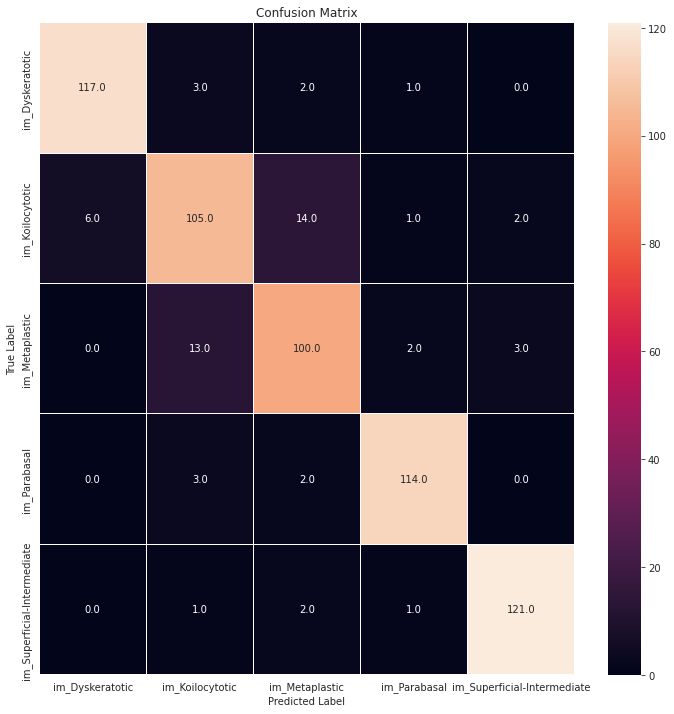

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report3 = classification_report(test_ds.classes, y_pred, target_names=cancer_classes, output_dict=True)
df2 = pd.DataFrame(report3).transpose()
df2

precision    recall  f1-score     support
im_Dyskeratotic               0.951220  0.951220  0.951220  123.000000
im_Koilocytotic               0.820312  0.840000  0.830040  125.000000
im_Metaplastic                0.847458  0.833333  0.840336  120.000000
im_Parabasal                  0.957983  0.957983  0.957983  119.000000
im_Superficial-Intermediate   0.968000  0.960317  0.964143  126.000000
accuracy                      0.908646  0.908646  0.908646    0.908646
macro avg                     0.908995  0.908571  0.908744  613.000000
weighted avg                  0.908975  0.908646  0.908772  613.000000

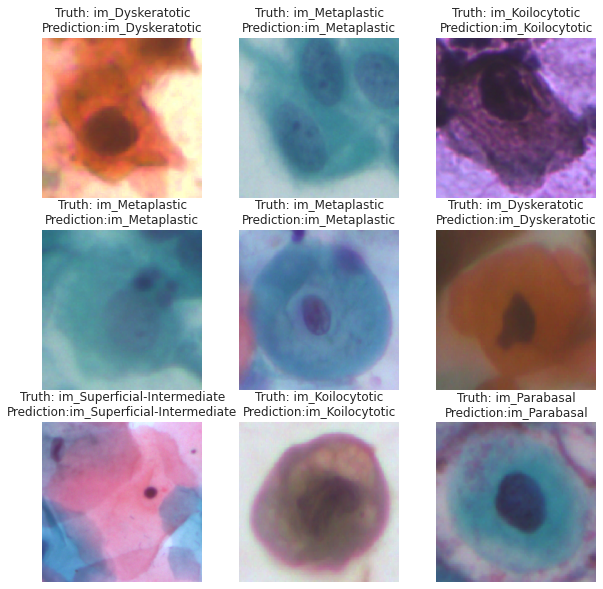

In [ ]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = densenet(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = cancer_classes[np.argmax(score)]
    plt.title(f'Truth: {cancer_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [ ]:
from keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import decode_predictions
from tensorflow.keras.applications.densenet import preprocess_input
densenet = DenseNet169(weights='imagenet')

58541896/58541896 [==============================] - 3s 0us/step


In [ ]:
yhat1 = densenet.predict(img1)
yhat2 = densenet.predict(img2)
yhat3 = densenet.predict(img3)
yhat4 = densenet.predict(img4)
yhat5 = densenet.predict(img5)
#decode predictions
label1 = decode_predictions(yhat1)
label2 = decode_predictions(yhat2)
label3 = decode_predictions(yhat3)
label4 = decode_predictions(yhat4)
label5 = decode_predictions(yhat5)
# extract top most prediction for each input
label1 = label1[0][0]
label2 = label2[0][0]
label3 = label3[0][0]
label4 = label4[0][0]
label5 = label5[0][0]

1/1 [==============================] - 0s 29ms/step


In [ ]:
#plt.imshow(image1)
print('%s (%.2f%%)' % (label1[1], label1[2]*100))
#plt.imshow(image2)
print('%s (%.2f%%)' % (label2[1], label2[2]*100))
#plt.imshow(image3)
print('%s (%.2f%%)' % (label3[1], label3[2]*100))
#plt.imshow(image4)
print('%s (%.2f%%)' % (label4[1], label4[2]*100))
print('%s (%.2f%%)' % (label5[1], label5[2]*100))

spotlight (99.75%)
artichoke (97.49%)
spotlight (99.93%)
goldfish (35.44%)
artichoke (64.06%)


In [ ]:
layer_idx = utils.find_layer_idx(densenet, 'predictions')
densenet.layers[-1].activation = tf.keras.activations.linear
densenet = utils.apply_modifications(densenet)

#get the input image index
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([118,944,118,1,944])

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

input_classes = ['im_Dyskeratotic','im_Koilocytotic','im_Metaplastic','im_Parabasal','im_Superficial-Intermediate']

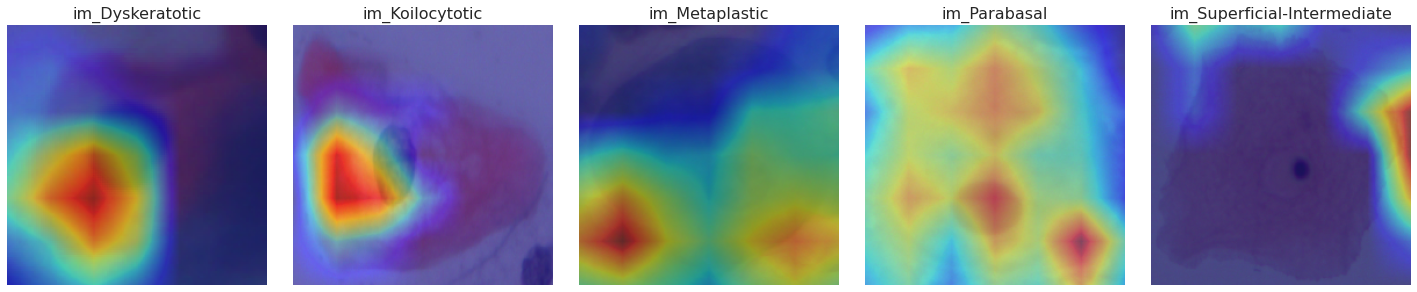

In [ ]:
input_images = preprocess_input(images)

# Create Gradcam object
gradcam = Gradcam(densenet,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              input_images,
              penultimate_layer=-1)

#show generated images



f, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, img_class in enumerate(input_classes):
    heatmap = np.uint8(cm.jet(cam[i])[..., :5] * 255)
    ax[i].set_title(img_class, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()